In [2]:
!pip install torch

!apt-get install -y xvfb python3-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup gym pyvirtualdisplay tensorflow ffmpeg imageio-ffmpeg > /dev/null 2>&1

zsh:1: no matches found: gym[classic_control]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import os
from typing import Dict, List, Tuple
from abc import ABC, abstractmethod
from gym import make
import numpy as np
from gym.wrappers.record_video import RecordVideo
import pickle
from typing import NamedTuple
from collections import defaultdict
from matplotlib import pyplot as plt
import random

In [4]:
#Load Cartpole Environment

#We define a custom CartPoleEnvironment class to represent the cartpole environment.

In [5]:
#Tuple to store different states
class Observation(NamedTuple):
    cart_position: float
    cart_velocity: float
    pole_angle: float
    pole_angular_velocity: float

In [6]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, state):
        return self.network(state)

In [7]:
from gym import make, wrappers
import numpy as np

class CartpoleEnvironment():
    
    def __init__(self, display: bool = False) -> None:
        self.env = make("CartPole-v1", render_mode="human" if display else None)
        self.observation, self.reward, self.done, self.truncated = self.env.reset(), 0.0, False, False

    def get_action_space(self):
        return self.env.action_space

    def get_observation(self) -> np.ndarray:
        return self.observation

    def update_environment(self, action: int) -> float:
        self.observation, self.reward, self.done, info = self.env.step(action)
        self.truncated = info.get('TimeLimit.truncated', False)
        return self.reward

    def is_end(self) -> bool:
        return not (-2.4 < self.observation[0] < 2.4) or not (-.2095 < self.observation[2] < .2095) or self.done or self.truncated

    def get_reward(self) -> float:
        return self.reward

    def reset_environment(self) -> np.ndarray:
        self.observation, self.reward, self.done, self.truncated = self.env.reset(), 0.0, False, False
        return self.observation

    def close_environment(self) -> None:
        self.env.close()
        self.env = make("CartPole-v1")

    def set_display_mode(self) -> None:
        self.env = make("CartPole-v1", render_mode="human")
        self.observation = self.env.reset()

    def set_video_recording(self, filename="rl-video"):
        self.env = wrappers.RecordVideo(self.env, video_folder="video", name_prefix=filename)
environment = CartpoleEnvironment()

/Users/nahid/opt/anaconda3/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/nahid/opt/anaconda3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
environment.get_action_space()
environment.get_observation()
environment.reset_environment()
print("Initial observations:", environment.get_observation())

Initial observations: [-0.01260766  0.03077381 -0.01134995 -0.014476  ]


In [9]:
#Base RL Agent

#We define an abstract base RL agent as follows:

In [49]:
class RLAgent(ABC):
    def __init__(self, env:CartpoleEnvironment) -> None:
        self._env = env
        self._total_reward: float = 0
        
    @abstractmethod
    def get_optimal_action(self, s: Observation) -> int:
        pass
    
    def move(self, state: Observation) -> float:
        if (self._env.is_end()):
            raise Exception("Episode already terminated")
        action = self.get_optimal_action(state)
        reward = self._env.update_environment(action)
        # update reward
        self._total_reward += reward
        return reward
    
    def run_single_episode_training(self) -> int:
        pass
    
    @abstractmethod
    def run_single_episode_production(self) -> int:
        pass
    
    def wrap_observation(self, observation: np.ndarray) -> Observation:
        """Converts numpy array to Observation object

        Args:
            observation (np.ndarray): array to pass in from cartpole

        Returns:
            Observation: Object to return
        """
        return Observation(*observation)
    
    def discretise_observation(self, observation: np.ndarray) -> Observation:
        # Adjusting bins for better state differentiation
        position_bins = np.linspace(-2.4, 2.4, num=24)  # Adjusted number of bins
        velocity_bins = np.linspace(-3, 3, num=24)  # Adjusted based on observed velocity range
        angle_bins = np.linspace(-0.418, 0.418, num=24)  # Adjusted for angle
        angular_velocity_bins = np.linspace(-3, 3, num=24)  # Adjusted based on observed angular velocity

        # Digitize (bin) each observation
        cart_position = np.digitize(observation[0], position_bins) - 1
        cart_velocity = np.digitize(observation[1], velocity_bins) - 1
        pole_angle = np.digitize(observation[2], angle_bins) - 1
        pole_angular_velocity = np.digitize(observation[3], angular_velocity_bins) - 1

        return Observation(cart_position, cart_velocity, pole_angle, pole_angular_velocity)

    

In [50]:
#1a

In [65]:
class MCAgent:
    def __init__(self, env, epsilon_decay=0.995, min_epsilon=0.1, gamma=0.99, load_pickle=False):
        self.env = env
        self.epsilon = 0.9  # Initial exploration rate
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.get_action_space().n))
        self.returns = defaultdict(list)
        self.num_runs = 0
        
        if load_pickle:
            self.load_pickle()  # Adjust this to the correct method name if different

    def decay_epsilon(self):
        """Decays epsilon after each episode with an improved approach."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)


    def train(self, episodes, report_every=100):
        """Trains the agent over a certain number of episodes."""
        total_rewards = []
        for episode_num in range(1, episodes + 1):
            total_reward = self.run_single_episode_training()
            total_rewards.append(total_reward)
            if episode_num % report_every == 0:
                average_reward = np.mean(total_rewards[-report_every:])
                print(f"Episode: {episode_num}, Average Reward: {average_reward}, Epsilon: {self.epsilon}")
        return total_rewards

            
    def save_model(self, filename="MC_parameters.pkl"):
        try:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'epsilon': self.epsilon,
                'total_reward': self.total_reward,
                'num_runs': self.num_runs,
            }, filename)
            print("Model saved successfully.")
        except Exception as e:
            print(f"Error saving model: {e}")

    def load_model(self, filename):
        if not os.path.exists(filename):
            print("*** Model file not found")
            return

        try:
            checkpoint = torch.load(filename, map_location=torch.device('cpu'))
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.epsilon = checkpoint['epsilon']
            self.total_reward = checkpoint.get('total_reward', 0)
            self.num_runs = checkpoint.get('num_runs', 0)
            print("Model loaded successfully.")
        except RuntimeError as e:
            print(f"RuntimeError loading model: {e}")
        except Exception as e:
            print(f"Error loading model: {e}")




    def run_single_episode_training(self):
        episode = []
        state = self.env.reset_environment()
        done = False

        while not done:
            action = self.get_optimal_action(state)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        self.update_q_table(episode)
        self.decay_epsilon()
        self.num_runs += 1
        total_reward = sum([x[2] for x in episode])
        return total_reward

    def run_single_episode_production(self) -> int:
        self.env.reset_environment()
        history = []
        total_reward = 0
        state = self.env.get_observation()  # Initial state

        while not self.env.is_end():
            action = self.get_optimal_action(state)  # Select action using the current model
            reward = self.env.update_environment(action)  # Take action and observe reward
            next_state = self.env.get_observation()  # Observe next state
            done = self.env.is_end()  # Check if the episode is done

            self.update_model(state, action, reward, next_state, done)  # Learn from this experience

            state = next_state  # Update state
            total_reward += reward

        self.decay_epsilon()  # Decay epsilon after each episode
        self.num_runs += 1
        self.total_reward += total_reward
        return total_reward


    def run_production(self, num_of_episode: int) -> None:
        return super().run_production(num_of_episode)
    
    def wrap_observation(self, observation: np.ndarray) -> Observation:
            """Converts a numpy array observation into a namedtuple Observation."""
            return Observation(*observation)
    def update_q_table(self, episode):
        """Updates the Q-table based on the returns from the episode."""
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G
            # Implement your MC update logic here based on G and your policy action)])

    def get_optimal_action(self, state):
        """Selects action based on epsilon-greedy policy."""
        if random.random() > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return self.env.get_action_space().sample()


    def save_pickle(self, filename="MC_agent.pkl"):
        with open(filename, 'wb') as f:
            pickle.dump({
                'Q': dict(self.Q),
                'returns': dict(self.returns),
                'epsilon': self.epsilon,
                'num_runs': self.num_runs
            }, f)
        print("Agent's state saved to", filename)

    def load_pickle(self, filename="MC_agent.pkl"):
        try:
            with open(filename, 'rb') as f:
                data = pickle.load(f)
                self.Q = defaultdict(lambda: np.zeros(self.env.get_action_space().n), data['Q'])
                self.returns = defaultdict(list, data['returns'])
                self.epsilon = data['epsilon']
                self.num_runs = data['num_runs']
            print("Agent's state loaded from", filename)
        except FileNotFoundError:
            print("File not found. Starting from scratch.")
    def print_average(self):
        print(f"avg_reward: {self.total_reward / self.num_runs}")

    def run_training_for_plot(self, num_of_episode: int) -> float:
        cumulated_reward = 0
        for _ in range(num_of_episode):
            cumulated_reward += self.run_single_episode_training()
        return cumulated_reward / num_of_episode
    
    def update_model(self, state, action, reward, next_state, done):
        state = torch.tensor([state], dtype=torch.float)
        next_state = torch.tensor([next_state], dtype=torch.float)
        action = torch.tensor([action], dtype=torch.long)
        reward = torch.tensor([reward], dtype=torch.float)

        # Get current Q-values
        q_values = self.model(state).gather(1, action.unsqueeze(-1)).squeeze(-1)
        # Compute the expected Q-values
        next_q_values = self.model(next_state).max(1)[0].detach()
        expected_q_values = reward + (self.gamma * next_q_values * (1 - done))

        # Compute loss
        loss = nn.MSELoss()(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def run_batch_episodes(self, episodes_per_batch):
        batch_rewards = []
        for _ in range(episodes_per_batch):
            total_reward = 0
            state = self.env.reset_environment()
            while not self.env.is_end():
                action = self.get_optimal_action(state)
                reward = self.env.update_environment(action)
                total_reward += reward
                state = self.env.get_observation()  # Get the new state
            batch_rewards.append(total_reward)
        return batch_rewards  # Return list of total rewards for each episode in the batch



mc_agent = MCAgent(environment, load_pickle=False)

In [66]:
def train_agent(episodes=1000):
    rewards = []
    for episode in range(episodes):
        total_reward = 0
        state = environment.reset_environment()
        episode_history = []  # To store state, action, reward for the episode
        
        while not environment.is_end():
            action = mc_agent.get_optimal_action(state)
            next_state = environment.get_observation()
            reward = environment.update_environment(action)
            done = environment.is_end()
            
            episode_history.append((state, action, reward))
            
            state = next_state
            total_reward += reward

        # Update Q-values based on the episode history
        mc_agent.update_q_table(episode_history)
        mc_agent.decay_epsilon()  # Adjust epsilon after each episode if necessary
        
        rewards.append(total_reward)
    
    return rewards


In [67]:


rewards = train_agent(episodes=1000)  # Or use the number of episodes you trained with

plt.plot(rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

print(f"Average Reward over the last 100 episodes: {np.mean(rewards[-100:]):.2f}")


TypeError: unhashable type: 'numpy.ndarray'

In [27]:
#Development of Monte Carlo Agent

#Below is the graph of how the MC agent develops over 10,000 iterations. we are interested in the initial rate of growth and how the agent progresses over time as it learns the optimal actions.

In [28]:
def run_batch_training(mc_agent, num_batches, episodes_per_batch):
    avg_rewards = []
    for _ in range(num_batches):
        total_reward = 0
        for _ in range(episodes_per_batch):
            total_reward += mc_agent.run_single_episode_training()
        avg_rewards.append(total_reward / episodes_per_batch)
    return avg_rewards

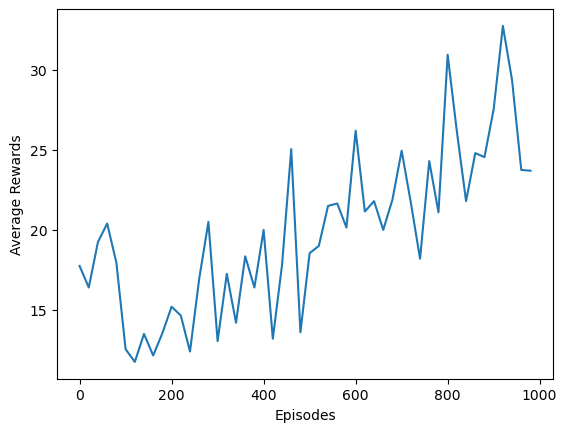

In [29]:
# Adjust these parameters based on your computation capacity and desired resolution of results
num_batches = 50  # This is the number of times we'll collect an average reward for plotting
episodes_per_batch = 20  # Number of episodes to run in each batch

# Run the batch training
avg_rewards = run_batch_training(mc_agent, num_batches, episodes_per_batch)

# Now plot the results
fig, ax = plt.subplots()
plt.plot([i*episodes_per_batch for i in range(num_batches)], avg_rewards)
ax.set_ylabel('Average Rewards')
ax.set_xlabel('Episodes')
plt.show()



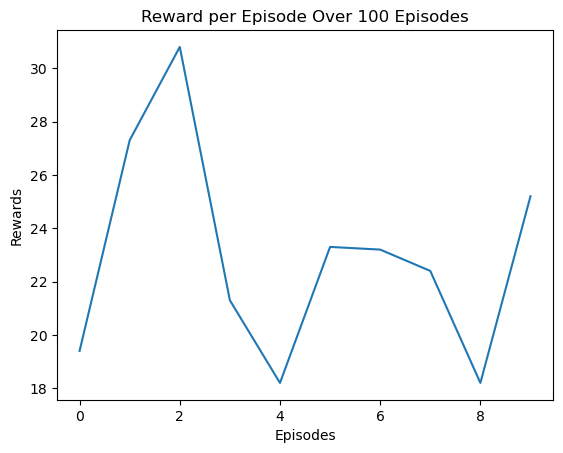

In [30]:
# 100 episodes in batches of 10
avg_rewards_100 = run_batch_training(mc_agent, num_batches=10, episodes_per_batch=10)
fig, ax = plt.subplots()
plt.plot(avg_rewards_100)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
plt.title('Reward per Episode Over 100 Episodes')
plt.show()

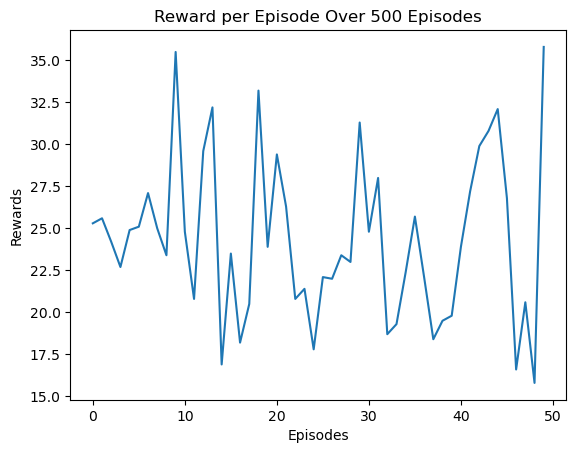

In [31]:
# 500 episodes in batches of 10
avg_rewards_500 = run_batch_training(mc_agent, num_batches=50, episodes_per_batch=10)
fig, ax = plt.subplots()
plt.plot(avg_rewards_500)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
plt.title('Reward per Episode Over 500 Episodes')
plt.show()

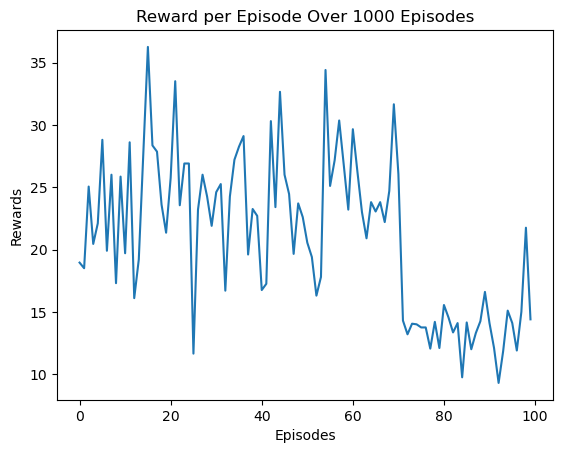

In [39]:
# 1000 episodes in batches of 20
avg_rewards_1000 = run_batch_training(mc_agent, num_batches=100, episodes_per_batch=20)
fig, ax = plt.subplots()
plt.plot(avg_rewards_1000)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
plt.title('Reward per Episode Over 1000 Episodes')
plt.show()

In [40]:
def evaluate_agent(agent, episodes):
    total_reward = 0
    for episode in range(episodes):
        # Reset the environment for evaluation
        agent.env.reset_environment()
        episode_reward = 0

        # Evaluate the agent's performance based on its learned policy
        while not agent.env.is_end():
            state = agent.env.get_observation()  # Get current state
            action = agent.get_optimal_action(state)  # Decide on an action
            reward = agent.env.update_environment(action)  # Execute the action and get the reward
            episode_reward += reward

        total_reward += episode_reward

    average_reward = total_reward / episodes
    return average_reward


In [41]:
# Number of episodes to evaluate the agent's performance
num_eval_episodes = 100

# Evaluate the agent
average_reward = evaluate_agent(mc_agent, num_eval_episodes)
print(f"Average Reward after {num_eval_episodes} episodes: {average_reward}")


Average Reward after 100 episodes: 9.74


In [36]:
# Task 1: Demonstrate the correctness of the implementation
# Resetting the environment and getting the initial observation
observation = environment.reset_environment()

# Convert the numpy array to Observation namedtuple
observation_converted = mc_agent.wrap_observation(observation)

# Retrieve the optimal action based on the current observation
action = mc_agent.get_optimal_action(observation_converted)

print(f"Observation: {observation_converted}")
print(f"Chosen Action: {action}")

Observation: Observation(cart_position=-0.04841956, cart_velocity=-0.01563277, pole_angle=0.0343956, pole_angular_velocity=0.044728775)
Chosen Action: 0


In [15]:
#1B

In [34]:
# define constants
MULTIPLICATIVE_DECAY=0
EXPONENTIAL_DECAY=1

class QLearningAgent(RLAgent):
    def __init__(self, env: CartpoleEnvironment, to_load_pickle=True, to_save_pickle=True,
                 max_epoch=100000, epsilon=0.9, epsilon_decay=MULTIPLICATIVE_DECAY, learning_rate_min=0.1) -> None:
        super().__init__(env)
        
        self.__learning_rate = 0.5
        self.__learning_rate_min = learning_rate_min
        self.__epsilon_decay = epsilon_decay
        self.__num_epoch = 0
        self.__max_epoch = max_epoch
        self.__epsilon = epsilon
        self._epsilon_min = 0.01
        self.__q_table = dict()  # Dictionary of (state, action) -> quality
        self.__pi_table = dict()  # Policy table
        if to_load_pickle:
            self.load_pickle('QL_parameters.pkl')
        self.__to_save_pickle = to_save_pickle
        self.__actions = [0, 1]  # [left, right] action set
        self.__discounted_reward = 0.9
        self.__is_production = False

    def print_parameters(self) -> None:
        print(f"Epsilon: {self.__epsilon:.2f}, Current epoch: {self.__num_epoch}, Learning rate: {self.__learning_rate:.2f}")

    def update_parameters(self) -> None:
        self.decay_epsilon()
        self.decay_learning_rate()

    def decay_epsilon(self) -> None:
        self.__num_epoch += 1
        if self.__epsilon <= self._epsilon_min:
            return

        if self.__epsilon_decay == MULTIPLICATIVE_DECAY:
            self.__epsilon *= 0.99999
        else:
            A = 0.5
            B = 0.1
            C = 0.1
            standardized_time = (self.__num_epoch - A * self.__max_epoch) / (B * self.__max_epoch)
            cosh = np.cosh(math.exp(-standardized_time))
            self.__epsilon = 1.1 - (1 / cosh + (self.__num_epoch * C / self.__max_epoch))

    def decay_learning_rate(self) -> None:
        decay_rate = 0.99995
        new_learning_rate = self.__learning_rate * decay_rate
        self.__learning_rate = max(new_learning_rate, self.__learning_rate_min)


    
    def train_till_complete(self, threshold: int, bin_size: int) -> List:
        self.__is_production = False
        cumulated_reward = 0
        reward_history = list()
        self.__num_epoch = 0
        while(cumulated_reward/bin_size < threshold):
            cumulated_reward = 0
            for _ in range(bin_size):
                reward = self.run_single_episode_training()
                cumulated_reward += reward
            reward_history.append(cumulated_reward/bin_size)
        self.print_parameters()
        return reward_history

    def run_training(self,  num_of_episode: int) -> List:
        """Overrides base class method

        Args:
            num_of_episode (int): Number of episode to run
        """
        self.__is_production = False
        cumulated_reward = 0
        reward_history = list()
        
        for _ in range(int(num_of_episode/100)):
            cumulated_reward = 0
            for _ in range(100):
                reward = self.run_single_episode_training()
                cumulated_reward += reward
            reward_history.append(cumulated_reward/100)

        self.print_parameters()
        if (self.__to_save_pickle):
            self.save_pickle("QL_parameters.pkl")
        return reward_history
    
    def run_training_for_plot(self,  num_of_episode: int) -> float:
        cumulated_reward = 0
        for _ in range(num_of_episode):
            cumulated_reward += self.run_single_episode_training()
        return cumulated_reward/num_of_episode
    
    def run_production(self, num_of_episode: int):
        self.__is_production = True
        
        cumulated_reward = 0
        for _ in range(num_of_episode):
            cumulated_reward += self.run_single_episode_production()

        print(f"Mean reward is: {cumulated_reward/num_of_episode} for {num_of_episode} episodes")

    def run_single_episode_training(self) -> int:
        # clear history
        self._env.reset_environment()
        self._total_reward = 0

        s_prime = self._env.get_observation()
        s_prime = self.discretise_observation(s_prime)

        while not self._env.is_end():  # Corrected method name here
            s = s_prime
            R = self.move(s)
            s_prime = self._env.get_observation()
            s_prime = self.discretise_observation(s_prime)

            self.update_q_table(s, R, s_prime)

        self.update_parameters()
        return self._total_reward

    
    def run_single_episode_production(self) -> int:
        # clear history
        self._env.reset_environment()
        ########
        self._total_reward = 0
        
        s_prime = self._env.get_observation()
        s_prime = self.discretise_observation(s_prime)
        
        while (not self._env.is_end()):
            s = s_prime
            R = self.move(s)
            s_prime = self._env.get_observation()
            s_prime = self.discretise_observation(s_prime)
        return self._total_reward

    def get_optimal_action(self, s: Observation) -> int:
        """Gets optimal action for given state

        Args:
            s (Observation): State observed

        Returns:
            int: action to take, subjected to epsilon soft policy
        """
        # a* is the policy from the pi table
        if (self.__is_production):
            a_star: int = self.get_policy(s)
            return a_star
        
        epsilon_over_A: float = self.__epsilon / len(self.__actions)
        
        # apply epsilon soft policy here to encourage exploration
        if (np.random.random_sample() < 1 - self.__epsilon + epsilon_over_A):
            # pick optimal
            self.__pi_table[s] = self.argmax_a_Q(s,self.__actions)
        else:
            # pick random
            self.__pi_table[s] = np.random.choice(2,1,self.__actions)[0]
        return self.__pi_table[s]
    
    def update_q_table(self,s: Observation, R: float, s_prime: Observation):
        Q_S_A = self.Q(s,self.__pi_table[s])
        Q_S_A = Q_S_A + self.__learning_rate * \
                (R + self.__discounted_reward*self.max_Q(s_prime,self.__actions) - Q_S_A)
        
        self.__q_table[(s,self.__pi_table[s])] = Q_S_A

    def Q(self, state: Observation, action: int) -> float:
        if ((state,action) in self.__q_table):
            return self.__q_table[(state,action)]
        else:
            self.__q_table[(state,action)] = 0
            return 0
    
    def max_Q(self, state: Observation, action_set: List[int]) -> float:
        """Gets the max value of Q over all actions

        Args:
            state (Observation): state observed
            action_set (List[int]): list of possible actions

        Returns:
            float: max value of Q for state
        """
        return max([self.Q(state,action) for action in action_set])

    def argmax_a_Q(self, state: Observation, action_set: List[int]) -> int:
        """Returns action that maximises Q function

        Args:
            state (Observation): state observed
            action_set (List[int]): list of actions possible

        Returns:
            int: action
        """
        return max([(action,self.Q(state,action)) for action in action_set],key=lambda item:item[1])[0]
    
    def get_policy(self, state: Observation):
        if (state not in self.__pi_table):
            # random action assigned
            self.__pi_table[state] = np.random.choice(2,1,self.__actions)[0]
            # create entry in Q-table
            for a in self.__actions: self.__q_table[(state,a)] = 0
        
        return self.__pi_table[state]
 
    def get_q_table(self):
        return self.__q_table
    
    def get_pi_table(self):
        return self.__pi_table
        
    def load_pickle(self, parameters_file: str):
        if os.path.exists(parameters_file):
            with open(parameters_file, 'rb') as file:
                self.__pi_table, self.__q_table, self.__epsilon, self.__learning_rate = pickle.load(file)
        else:
            print("*** LOG: Pickle file not found")
        
    def save_pickle(self, parameters_file: str):
        if self.__to_save_pickle:
            with open(parameters_file, 'wb') as file:
                pickle.dump([self.__pi_table, self.__q_table, self.__epsilon, self.__learning_rate], file)
                print("Agent state saved to", parameters_file)

qlearning_agent = QLearningAgent(environment, to_load_pickle=False, to_save_pickle=True)



In [ ]:

# Assuming num_episodes is defined
num_episodes = 100000  # Total number of episodes to train
batch_size = 100       # Number of episodes to average for plotting

# Parameters to explore
learning_rates = [0.01, 0.1, 0.2]
epsilons = [0.2, 0.5, 1.0]
epsilon_decays = [MULTIPLICATIVE_DECAY, EXPONENTIAL_DECAY]

# Function to plot the rewards
def plot_rewards(reward_history, lr, eps, decay_strategy):
    fig, ax = plt.subplots()
    ax.plot(reward_history)
    ax.set_ylabel('Average Rewards')
    ax.set_xlabel(f'Episodes (in batches of {batch_size})')
    decay_str = "Multiplicative" if decay_strategy == MULTIPLICATIVE_DECAY else "Exponential"
    ax.set_title(f'Learning Rate: {lr}, Epsilon: {eps}, Decay: {decay_str}')
    plt.grid(True)
    plt.show()

# Training and plotting
for lr in learning_rates:
    for eps in epsilons:
        for decay_strategy in epsilon_decays:
            qlearning_agent = QLearningAgent(
                env=environment,
                to_load_pickle=False,
                to_save_pickle=True,
                max_epoch=num_episodes,
                epsilon=eps,
                epsilon_decay=decay_strategy,
                learning_rate_min=lr
            )
            
            # Run the training
            reward_history = []
            for episode in range(0, num_episodes, batch_size):
                batch_rewards = 0
                for _ in range(batch_size):
                    batch_rewards += qlearning_agent.run_single_episode_training()
                avg_batch_reward = batch_rewards / batch_size
                reward_history.append(avg_batch_reward)
            
            # Plot the results for this combination of parameters
            plot_rewards(reward_history, lr, eps, decay_strategy)


In [118]:
#Choosing the best hyper parameters
#Having tested different parameters, we have identified the 2 best graph which gets the agent to about 400 rewards with the shortest training time.

In [ ]:
#Correctness of implementation

In [35]:
# Resetting the environment and getting the initial observation
observation = environment.reset_environment()

# Convert the numpy array to Observation namedtuple
observation_converted = qlearning_agent.wrap_observation(observation)

# Retrieve the optimal action based on the current observation
action = qlearning_agent.get_optimal_action(observation_converted)

print(f"Observation: {observation_converted}")
print(f"Chosen Action: {action}")


Observation: Observation(cart_position=0.04829857, cart_velocity=0.035396256, pole_angle=-0.040336132, pole_angular_velocity=0.042181958)
Chosen Action: 0


In [18]:
#Task 2:

#Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

In [19]:
#2a) Effectiveness of MC Agent

#The code below loads the pickle file containing the pickle file for the agent to load from.



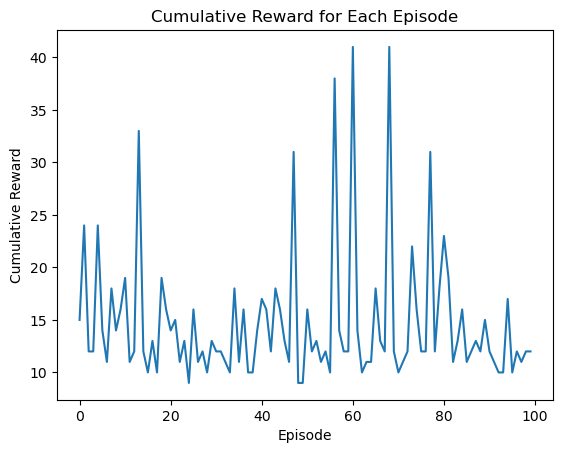

Average cumulative reward over 100 episodes: 14.66
Is the agent good enough? No


In [38]:
# Define the number of episodes for evaluation
num_eval_episodes = 100
cumulative_rewards = []

# Evaluate the agent over multiple episodes
for _ in range(num_eval_episodes):
    total_reward = 0
    environment.reset_environment()  # Reset the environment for a new episode
    state = environment.get_observation()  # Properly obtain the initial state
    state = mc_agent.wrap_observation(state)  # Make sure this is done for QLearningAgent if necessary
    
    while not environment.is_end():
        action = mc_agent.get_optimal_action(state)  # Select the action using the agent's policy
        reward = environment.update_environment(action)  # Execute the action and get the reward
        state = environment.get_observation()  # Update the state
        state = mc_agent.wrap_observation(state)  # Wrap the state again for the next step
        total_reward += reward  # Accumulate the reward
    cumulative_rewards.append(total_reward)  # Store the cumulative reward for this episode
# Convert the list to a numpy array for mean calculation
cumulative_rewards = np.array(cumulative_rewards)
average_cumulative_reward = np.mean(cumulative_rewards)  # Calculate the average cumulative reward

# Check if the agent is good enough
is_agent_good_enough = average_cumulative_reward > 195

# Plot the cumulative rewards
plt.plot(cumulative_rewards)
plt.title('Cumulative Reward for Each Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

# Print the results
print(f"Average cumulative reward over {num_eval_episodes} episodes: {average_cumulative_reward:.2f}")
print(f"Is the agent good enough? {'Yes' if is_agent_good_enough else 'No'}")


In [142]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)


Average cumulative reward: 20.57
Is my agent good enough? False


In [143]:
#2b) Effectiveness of Q-Learning Agent

#The code below loads the pickle file containing the pickle file for the agent to load from.

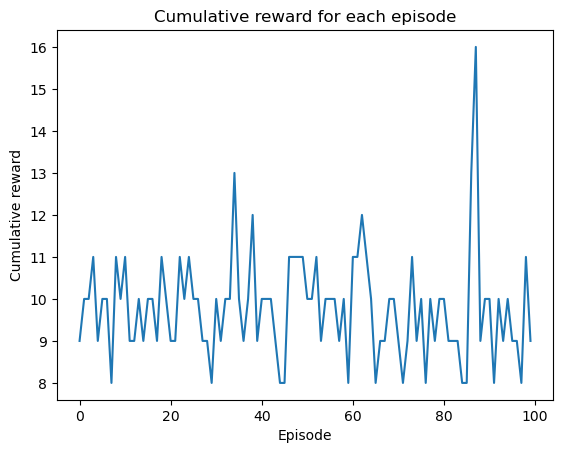

In [144]:
environment = CartpoleEnvironment()
qlearning_agent = QLearningAgent(environment, to_load_pickle=True, to_save_pickle=False)
episode_results = np.asarray([qlearning_agent.run_single_episode_production() for _ in range(100)])

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()


In [145]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)


Average cumulative reward: 9.78
Is my agent good enough? False


In [146]:
#Task 3:

#Render one episode played by the developed RL agent on Jupyter. Please refer to the sample code link for rendering code

In [147]:
#3a) Render single episode of MC Agent

In [150]:
environment.set_display_mode()
mc_agent = MCAgent(environment,load_pickle=True)
reward = mc_agent.run_single_episode_production()
world.close_display()

print(f"Reward is: {reward}")

RuntimeError loading model: Invalid magic number; corrupt file?


NameError: name 'world' is not defined

In [ ]:
environment.set_video_recording(filename="MCAgent")
mc_agent = MCAgent(environment,load_pickle=True)
reward = mc_agent.run_single_episode_production()
environment.close_display()

print(f"Reward is: {reward}")

In [ ]:
#3b) Render single episode of Q-Learning Agent

In [ ]:
# Render video with pop up
environment.set_to_display_mode()
qlearning_agent = QLearningAgent(environment,to_load_pickle=True,to_save_pickle=False)
reward = qlearning_agent.run_single_episode_production()
environment.close_display()

print(f"Reward is: {reward}")

In [ ]:
# Save the video file
environment.set_save_video(filename="QLAgent")
qlearning_agent = QLearningAgent(world,to_load_pickle=True,to_save_pickle=False)
reward = qlearning_agent.run_single_episode_production()
environment.close_display()

print(f"Reward is: {reward}")